In [1]:
import sys
from pathlib import Path

# Notebook ka folder
NOTEBOOK_DIR = Path().resolve()

# Project root = parent folder
PROJECT_ROOT = NOTEBOOK_DIR.parent

# Add project root to import path
sys.path.append(str(PROJECT_ROOT))

print("Project root:", PROJECT_ROOT)


Project root: D:\Langchain_LangGraph_03-12-2025\MyProject


In [2]:
#now importing all the Module which is used to build the AI Model.
from langchain_core.prompts import PromptTemplate,ChatPromptTemplate
from exception import CustomException
from logger_config import logger
import os,sys

#using openai chat model and embedding models
from langchain_openai import ChatOpenAI,OpenAIEmbeddings

#using groq chat model 
from langchain_groq import ChatGroq

#using open source chat model from hugging Face
from langchain_huggingface import ChatHuggingFace,HuggingFaceEmbeddings,HuggingFaceEndpoint

from config import *

from langchain_core.runnables import RunnableBranch,RunnableLambda,RunnableParallel,RunnableSequence,RunnablePassthrough

[2025-12-10 00:21:07,198]-config_variable.py-INFO -Loading the environment Variable
[2025-12-10 00:21:07,202]-config_variable.py-INFO -Environment Variable successfully Loaded


In [3]:
%pwd

'd:\\Langchain_LangGraph_03-12-2025\\MyProject\\notebooks'

In [4]:
#import Langgraph related Modules
import langgraph
from langgraph.graph import StateGraph,START,END
from dataclasses import dataclass
from typing import TypedDict
from typing import Literal,List,Annotated
from langchain_core.messages import AnyMessage,AIMessage,HumanMessage,ToolMessage

from pydantic import BaseModel #using this class we can perform validation to schema

from langgraph.prebuilt import tool_node,tools_condition #in this class we put all tools together
#tools_condition wrt to tool msg it will route the flow data to ttol node to perform execution

from langchain_core.tools import tool,Tool,StructuredTool

from langgraph.graph.message import BaseMessage #this is special class which hold every mesaage init.



## step:1) defining the models components

In [5]:
model1 = ChatOpenAI(
    model="gpt-3.5-turbo",
    temperature=0.2 #we call as creative parameter
)
model1

ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x0000028E625E38E0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x0000028E6284D1F0>, root_client=<openai.OpenAI object at 0x0000028E625E3610>, root_async_client=<openai.AsyncOpenAI object at 0x0000028E6277D850>, temperature=0.2, model_kwargs={}, openai_api_key=SecretStr('**********'), stream_usage=True)

In [6]:
model2 = ChatGroq(
    model="llama-3.1-8b-instant",
    temperature=0.2 #we call as creative parameter
)
model2

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000028E62F11DC0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000028E62F173A0>, model_name='llama-3.1-8b-instant', temperature=0.2, model_kwargs={}, groq_api_key=SecretStr('**********'))

In [7]:
llm = HuggingFaceEndpoint(  
repo_id="meta-llama/Llama-3.1-8B-Instruct",  
task="text-generation",  
max_new_tokens=512,  
do_sample=False,  
repetition_penalty=1.03,  
)  

model3 = ChatHuggingFace(llm=llm, verbose=True)
model3

ChatHuggingFace(llm=HuggingFaceEndpoint(repo_id='meta-llama/Llama-3.1-8B-Instruct', repetition_penalty=1.03, stop_sequences=[], server_kwargs={}, model_kwargs={}, model='meta-llama/Llama-3.1-8B-Instruct', client=<InferenceClient(model='meta-llama/Llama-3.1-8B-Instruct', timeout=120)>, async_client=<InferenceClient(model='meta-llama/Llama-3.1-8B-Instruct', timeout=120)>, task='text-generation'), model_id='meta-llama/Llama-3.1-8B-Instruct', model_kwargs={})

## building different type of complex workflows using LangGraph

### 1) building Normal Agentic workflow by langchain

In [8]:
from langchain.agents import create_react_agent,AgentExecutor
from langchain import hub

In [9]:
react_prompt = hub.pull("hwchase17/react")
react_prompt

PromptTemplate(input_variables=['agent_scratchpad', 'input', 'tool_names', 'tools'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'hwchase17', 'lc_hub_repo': 'react', 'lc_hub_commit_hash': 'd15fe3c426f1c4b3f37c9198853e4a86e20c425ca7f4752ec0c9b0e97ca7ea4d'}, template='Answer the following questions as best you can. You have access to the following tools:\n\n{tools}\n\nUse the following format:\n\nQuestion: the input question you must answer\nThought: you should always think about what to do\nAction: the action to take, should be one of [{tool_names}]\nAction Input: the input to the action\nObservation: the result of the action\n... (this Thought/Action/Action Input/Observation can repeat N times)\nThought: I now know the final answer\nFinal Answer: the final answer to the original input question\n\nBegin!\n\nQuestion: {input}\nThought:{agent_scratchpad}')

## now providing the tools support to llm

In [10]:
from tavily import TavilyClient

tavily_client = TavilyClient()


def tavily_search_tool(query: str) -> str:
    """
    Search the web using Tavily and return summarized results.

    Args:
        query (str): Search query provided by the user.

    Returns:
        str: Search results as text.
    """
    response = tavily_client.search(query=query, max_results=1)
    
    results = response.get("results", [])
    summaries = [
        f"{r['title']}: {r['content'][:120]}"
        for r in results
    ]
    return "\n".join(summaries)


search_tool = Tool(
    name='search',
    func=tavily_search_tool,
    description="Search the internet for up-to-date information"
)

In [11]:
# from langchain_exa import ExaSearchResults

# # Initialize the ExaSearchResults tool
# search_tool = ExaSearchResults(
#     num_results=1,
#     highlights=False,
#     text_contents_options={"max_characters": 1000}
# )
from typing import Union

In [12]:
from pydantic import BaseModel, Field
class MultiplyArgs(BaseModel):
    a: int = Field(..., description="First number")
    b: int = Field(..., description="Second number")

@tool(args_schema=MultiplyArgs)
def Multiplication(a: int, b: int) -> int:
    """Multiply two integers."""
    return a * b

In [13]:
#combining all tools together.
lst_tools=[search_tool,Multiplication]
lst_tools

[Tool(name='search', description='Search the internet for up-to-date information', func=<function tavily_search_tool at 0x0000028E649328B0>),
 StructuredTool(name='Multiplication', description='Multiply two integers.', args_schema=<class '__main__.MultiplyArgs'>, func=<function Multiplication at 0x0000028E649FA5E0>)]

### now creating an agents that can think and react based on user query

In [14]:
thinkagent = create_react_agent(
    llm=model2,
    tools=lst_tools,
    prompt=react_prompt
)
thinkagent

RunnableAssign(mapper={
  agent_scratchpad: RunnableLambda(lambda x: format_log_to_str(x['intermediate_steps']))
})
| PromptTemplate(input_variables=['agent_scratchpad', 'input'], input_types={}, partial_variables={'tools': 'search(query: str) -> str - Search the internet for up-to-date information\nMultiplication(a: int, b: int) -> int - Multiply two integers.', 'tool_names': 'search, Multiplication'}, metadata={'lc_hub_owner': 'hwchase17', 'lc_hub_repo': 'react', 'lc_hub_commit_hash': 'd15fe3c426f1c4b3f37c9198853e4a86e20c425ca7f4752ec0c9b0e97ca7ea4d'}, template='Answer the following questions as best you can. You have access to the following tools:\n\n{tools}\n\nUse the following format:\n\nQuestion: the input question you must answer\nThought: you should always think about what to do\nAction: the action to take, should be one of [{tool_names}]\nAction Input: the input to the action\nObservation: the result of the action\n... (this Thought/Action/Action Input/Observation can repeat N

### now using agentexecutor that will execute the agent and also validating response is based on query or not

In [15]:
agentexecutor = AgentExecutor(
    agent=thinkagent,
    tools=lst_tools,
    verbose=True,
    #max_iterations=6,          # 🔥 VERY IMPORTANT
    #early_stopping_method="force"
)
agentexecutor

AgentExecutor(verbose=True, agent=RunnableAgent(runnable=RunnableAssign(mapper={
  agent_scratchpad: RunnableLambda(lambda x: format_log_to_str(x['intermediate_steps']))
})
| PromptTemplate(input_variables=['agent_scratchpad', 'input'], input_types={}, partial_variables={'tools': 'search(query: str) -> str - Search the internet for up-to-date information\nMultiplication(a: int, b: int) -> int - Multiply two integers.', 'tool_names': 'search, Multiplication'}, metadata={'lc_hub_owner': 'hwchase17', 'lc_hub_repo': 'react', 'lc_hub_commit_hash': 'd15fe3c426f1c4b3f37c9198853e4a86e20c425ca7f4752ec0c9b0e97ca7ea4d'}, template='Answer the following questions as best you can. You have access to the following tools:\n\n{tools}\n\nUse the following format:\n\nQuestion: the input question you must answer\nThought: you should always think about what to do\nAction: the action to take, should be one of [{tool_names}]\nAction Input: the input to the action\nObservation: the result of the action\n... (

### now invoking agent to perform execution

In [16]:
response = agentexecutor.invoke(input={'input':
    "Summarize in one line the best route from Andheri, Mumbai (source) to Borivali (destination)."})
response



> Entering new AgentExecutor chain...
[2025-12-10 00:21:11,350]-_client.py-INFO -HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
Thought: To find the best route from Andheri to Borivali, I need to know the public transportation options available in Mumbai.
Action: search
Action Input: "best route from Andheri to Borivali Mumbai"Andheri (Station) to Borivali - 5 ways to travel via train, and line 203 ...: The best way to get from Andheri (Station) to Borivali is to train which takes 24 min and costs ₹6 - ₹70. Alternatively,[2025-12-10 00:21:12,593]-_client.py-INFO -HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
Question: Summarize in one line the best route from Andheri, Mumbai (source) to Borivali (destination).
Thought: To find the best route from Andheri to Borivali, I need to know the public transportation options available in Mumbai.
Action: search
Action Input: "best route from Andheri to Borivali Mumbai"

{'input': 'Summarize in one line the best route from Andheri, Mumbai (source) to Borivali (destination).',
 'output': 'The best route from Andheri to Borivali is by train, which takes 24 minutes and costs ₹6 - ₹70.'}

## Now Building Agent using LangGraph

### 1) building Agentic workflow by langchain

#### defining state or memory schema for this workflow

In [17]:
from langgraph.graph.message import add_messages
class AgentSchema(TypedDict):
    messages : Annotated[list[str],add_messages]

In [18]:
#now defining the graph object by passing state memory into it.
graph = StateGraph(state_schema=AgentSchema)
graph

In [19]:
lst_tools

[Tool(name='search', description='Search the internet for up-to-date information', func=<function tavily_search_tool at 0x0000028E649328B0>),
 StructuredTool(name='Multiplication', description='Multiply two integers.', args_schema=<class '__main__.MultiplyArgs'>, func=<function Multiplication at 0x0000028E649FA5E0>)]

In [20]:
#now adding the nodes  to graph.
#1)llmwithtools 2)toolnode
def LLMWithToolNode(state:AgentSchema)->AgentSchema:
    #now fetching the latest message from state.
    latest_msg = state['messages']
    
    #now wrapping the llm with tool.
    llm_with_tool = model1.bind_tools(tools=lst_tools)
    
    #converting dynamic user prompt to structure instruction prompt.
    prompt = PromptTemplate(
        template="""
        
        You are an intelligent AI assistant acting as a tool-augmented agent.

        Your job is to:
        1. Understand the user's latest message.
        2. Decide whether a tool is required to answer the request.
        3. If a tool is required, select the most relevant tool and provide accurate inputs.
        4. If no tool is required, answer directly using your knowledge.
        5. Never hallucinate tool results — only use tool outputs when they are actually executed.
        6. Produce clear, concise, and helpful responses.

        TOOLS AVAILABLE:
        {lst_tools}

        CONVERSATION HISTORY:
        {latest_msg}
        
        """,input_variables=['lst_tools','latest_msg']
        
    )
    
    #forming chain to perform execution.
    chain = prompt | llm_with_tool
    
    #invoking the chain for execution.
    response= chain.invoke(input={'lst_tools':lst_tools,'latest_msg':latest_msg})
    
    
    return {
        'messages': [response]
    }

In [21]:
from langgraph.prebuilt import ToolNode,tools_condition

toolnode = ToolNode(tools=lst_tools)
tool_node

<module 'langgraph.prebuilt.tool_node' from 'c:\\anaconda\\envs\\tf-gpu\\lib\\site-packages\\langgraph\\prebuilt\\tool_node.py'>

In [22]:
#now adding tools and nodes to graph to build workflow.
graph.add_node(node="LLMWithToolNode",action=LLMWithToolNode)
graph.add_node(node="toolnode",action=toolnode)
graph.add_edge(start_key=START,end_key="LLMWithToolNode")

graph.add_conditional_edges(
    'LLMWithToolNode',
    tools_condition,
    {
        "tools":"toolnode",
        "__end__":END
    }
##tools_condition check wheather tool msg present from reposne coming from chat_node if yes redirect to tool_node or else will end.
)
graph.add_edge(start_key="toolnode",end_key="LLMWithToolNode")

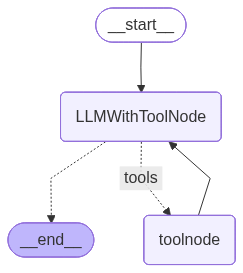

In [23]:
workflow = graph.compile()
workflow

In [24]:
#now defining an initializing initial state.
state = AgentSchema(messages=[HumanMessage("What is 2 multiply by 3")])

#now passing the state to workflow.
result = workflow.invoke(input=state)

for msg in result['messages']:
     msg.pretty_print()
    

[2025-12-10 00:21:20,315]-_client.py-INFO -HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[2025-12-10 00:21:21,311]-_client.py-INFO -HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
================================ Human Message =================================

What is 2 multiply by 3
================================== Ai Message ==================================
Tool Calls:
  Multiplication (call_LLxYlswX1zKuVTcsw6CYkE7T)
 Call ID: call_LLxYlswX1zKuVTcsw6CYkE7T
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: Multiplication

6
================================== Ai Message ==================================

The result of multiplying 2 by 3 is 6. This calculation was performed using the Multiplication tool. If you have any more questions or need further assistance, feel free to ask!


In [25]:
#now defining an initializing initial state.
state = AgentSchema(messages=[HumanMessage("Summarize in one line the best route from Andheri, Mumbai (source) to Borivali (destination).")])

#now passing the state to workflow.
result = workflow.invoke(input=state)

for msg in result['messages']:
     msg.pretty_print()
    

[2025-12-10 00:22:36,828]-_client.py-INFO -HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
================================ Human Message =================================

Summarize in one line the best route from Andheri, Mumbai (source) to Borivali (destination).
================================== Ai Message ==================================

To summarize in one line, the best route from Andheri, Mumbai to Borivali is to take the Western Express Highway.
